In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import f
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller as adf

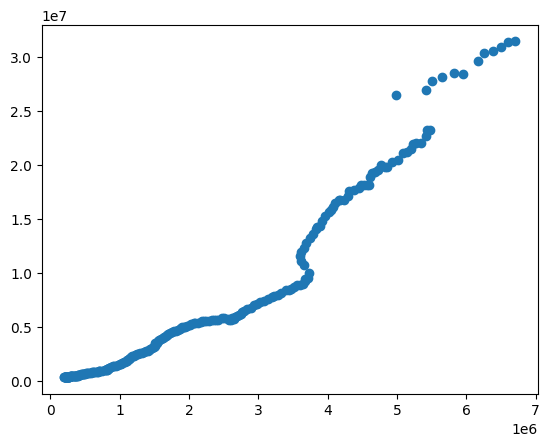

In [2]:
gdp = pd.read_csv("US_Nominal_GDP.csv")
debt = pd.read_csv("public_debt.csv")
gdp = gdp.rename(columns={'DATE': 'date', 'NGDPSAXDCUSQ': 'value'})
gdp = gdp.iloc[64:len(gdp)-5, :].reset_index().iloc[:, 1:]
X = np.array(gdp["value"])
Y = np.array(debt["value"])
#G = np.array(gdp["value"])
#D = np.array(debt["value"])
#X = G.copy()
#Y = D.copy()
#for i in range(4, len(G)):
#    X[i] = (G[i] - G[i - 4])/G[i - 4]
#    Y[i] = (D[i] - D[i - 4])/D[i - 4]
#X = X[4:]
#Y = Y[4:]
#X = X/1e6
#Y = Y/1e6
plt.scatter(X, Y)

In [3]:
def weighted_simple_quad(X, Y, w):
    Y_new = Y/np.sqrt(w)
    X_new_1 = X/np.sqrt(w)
    X_new_2 = X**2/np.sqrt(w)
    X_new_0 = 1/np.sqrt(w)
    X_new = np.column_stack((X_new_2, X_new_1, X_new_0))
    Y_new = np.column_stack((Y_new)).T
    p = np.dot(np.dot(np.linalg.inv(np.dot(X_new.T, X_new)), X_new.T), Y_new)
    p = p.T[0]
    return p

In [4]:
def weighted_simple_lin(X, Y, w):
    Y_new = Y/np.sqrt(w)
    X_new_1 = X/np.sqrt(w)
    X_new_0 = 1/np.sqrt(w)
    X_new = np.column_stack((X_new_1, X_new_0))
    Y_new = np.column_stack((Y_new)).T
    p = np.dot(np.dot(np.linalg.inv(np.dot(X_new.T, X_new)), X_new.T), Y_new)
    p = p.T[0]
    return p

In [5]:
def linReg(x, y, eps = 1e-3):
    Beta0 = np.polyfit(X, Y, 1)
    w = np.abs(Y - Beta0[0] * X - Beta0[1])
    Beta1 = weighted_simple_lin(X, Y, w)
    e = 1
    while (np.linalg.norm(Beta0 - Beta1) > eps):
        Beta0 = Beta1
        w = np.abs(Y - Beta0[0] * X - Beta0[1])
        Beta1 = weighted_simple_lin(X, Y, w)
        e += 1
    return Beta0

In [6]:
def quadReg(X, Y, eps = 1e-3):
    Beta0 = np.polyfit(X, Y, 2)
    w = np.abs(Y - Beta0[0] * X**2 - Beta0[1] * X - Beta0[2])
    Beta1 = weighted_simple_quad(X, Y, w)
    e = 1
    while (np.linalg.norm(Beta0 - Beta1) > eps):
        Beta0 = Beta1
        w = np.abs(Y - Beta0[0] * X**2 - Beta0[1] * X - Beta0[2])
        Beta1 = weighted_simple_quad(X, Y, w)
        e += 1
    return Beta0

In [7]:
def F_Value_Lin(X, Y, z):
    X1 = X[X <= z]
    Y1 = Y[X <= z]
    X2 = X[X > z]
    Y2 = Y[X > z]
    B1 = linReg(X1, Y1)
    B2 = linReg(X2, Y2)
    B = linReg(X, Y)
    e1 = Y1 - np.dot(np.hstack((X1.reshape((len(X1), 1)), np.ones((len(X1), 1)))), B1)
    e2 = Y2 - np.dot(np.hstack((X2.reshape((len(X2), 1)), np.ones((len(X2), 1)))), B2)
    e = Y - np.dot(np.hstack((X.reshape((len(X), 1)), np.ones((len(X), 1)))), B)
    e = np.abs(e)
    e1 = np.abs(e1)
    e2 = np.abs(e2)
    n = len(X1)
    m = len(X2)
    p = 2
    f_v = (n + m - 2*p)/p * (np.sum(e) - np.sum(e1) - np.sum(e2))/(np.sum(e1) + np.sum(e2))
    return 1 - f.cdf(f_v, p, n + m - 2*p)

In [8]:
def F_Value_Quad(X, Y, z):
    X1 = X[X <= z]
    Y1 = Y[X <= z]
    X2 = X[X > z]
    Y2 = Y[X > z]
    B1 = quadReg(X1, Y1)
    B2 = quadReg(X2, Y2)
    B = quadReg(X, Y)
    e1 = Y1 - np.dot(np.hstack(((X1**2).reshape((len(X1), 1)), X1.reshape((len(X1), 1)), np.ones((len(X1), 1)))), B1)
    e2 = Y2 - np.dot(np.hstack(((X2**2).reshape((len(X2), 1)), X2.reshape((len(X2), 1)), np.ones((len(X2), 1)))), B2)
    e = Y - np.dot(np.hstack(((X**2).reshape((len(X), 1)), X.reshape((len(X), 1)), np.ones((len(X), 1)))), B)
    e = np.abs(e)
    e1 = np.abs(e1)
    e2 = np.abs(e2)
    n = len(X1)
    m = len(X2)
    p = 3
    f_v = (n + m - 2*p)/p * (np.sum(e) - np.sum(e1) - np.sum(e2))/(np.sum(e1) + np.sum(e2))
    return 1 - f.cdf(f_v, p, n + m - 2*p)

In [9]:
F_Value_Lin(X, Y, 3)

1.0

In [10]:
F_Val_Lin = []
for i in range(0, len(X)):
    try:
        F_Val_Lin.append(F_Value_Lin(X, Y, X[i]))
    except:
        F_Val_Lin.append(1e30)
F_Val_Lin = np.array(F_Val_Lin)
print(min(F_Val_Lin))
print(X[np.where(F_Val_Lin == min(F_Val_Lin))[0][0]])

0.9999999999999623
5957243.5


In [11]:
q = quadReg(X, Y)
Y_new = q[0]*X**2 + q[1]*X + q[2]

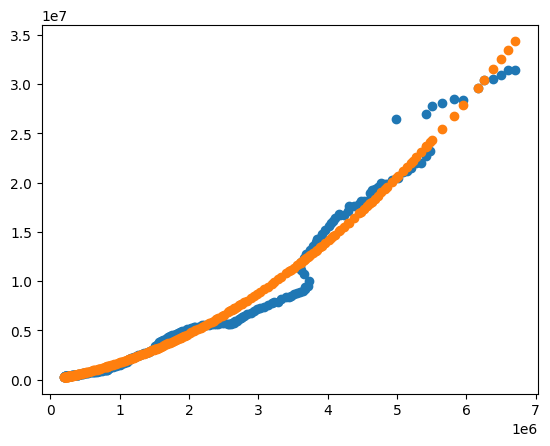

In [12]:
plt.scatter(X, Y)
plt.scatter(X, Y_new)

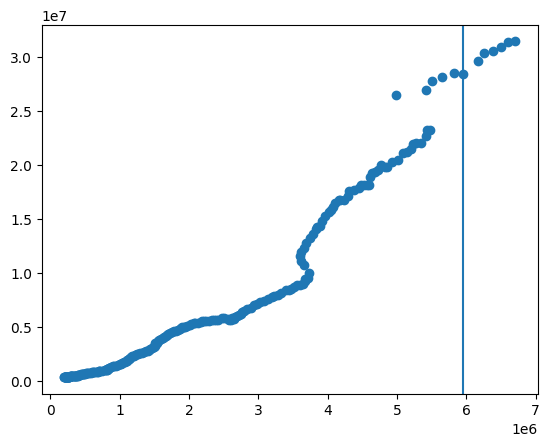

In [13]:
plt.scatter(X, Y)
plt.axvline(X[np.where(F_Val_Lin == min(F_Val_Lin))[0][0]])

In [14]:
F_Val_Quad = []
for i in range(0, len(X)):
    try:
        F_Val_Quad.append(F_Value_Quad(X, Y, X[i]))
    except:
        F_Val_Quad.append(1e9)
F_Val_Quad = np.array(F_Val_Quad)
print(min(F_Val_Quad))
print(X[np.where(F_Val_Quad == min(F_Val_Quad))[0][0]])

/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ipykernel_9969/23507724.py:2: RankWarning: Polyfit may be poorly conditioned
  Beta0 = np.polyfit(X, Y, 2)
/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ipykernel_9969/2910035228.py:2: RuntimeWarning: divide by zero encountered in divide
  Y_new = Y/np.sqrt(w)
/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ipykernel_9969/2910035228.py:3: RuntimeWarning: divide by zero encountered in divide
  X_new_1 = X/np.sqrt(w)
/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ipykernel_9969/2910035228.py:4: RuntimeWarning: divide by zero encountered in divide
  X_new_2 = X**2/np.sqrt(w)
/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ipykernel_9969/2910035228.py:5: RuntimeWarning: divide by zero encountered in divide
  X_new_0 = 1/np.sqrt(w)
/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ipykernel_9969/23507724.py:2: RankWarning: Polyfit may be poorly conditioned
  Beta0 = np.polyfit(X, Y, 2)
/var/folders/v9/5bvvpz4n1d5b0x86cn_kvkz80000gp/T/ip

1.1102230246251565e-16
3509890.0


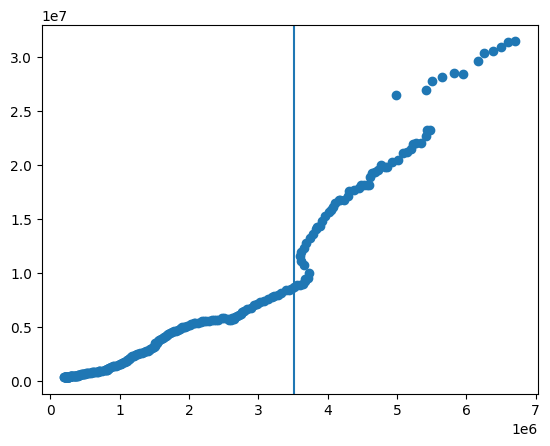

In [15]:
You do plt.scatter(X, Y)
plt.axvline(X[np.where(F_Val_Quad == min(F_Val_Quad))[0][0]])